**AUTHOR - ARYAMAN ADIVYA SINGH**

**PROBLEM STATEMENT**

The objective of the project is to implement language translation model aka machine translation for converting German to English (and vice versa) For this, the data is a text file (.txt) of English-German sentence pairs. The actual data contains over 150,000 sentence-pairs. However, it is suggested to use only the first 50,000 sentence pairs to reduce the training time of the model. You can download the Data set from http://www.manythings.org/anki/

In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
import numpy as np
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
from matplotlib.axis import Axis
%matplotlib inline
pd.set_option('display.max_colwidth',200)
print('Import Success')

Import Success


In [20]:
def read_text(filename):
    #Opening the File
    file = open(filename,mode='rt')
    #Read the File
    text = file.read()
    file.close()
    return text

In [3]:
#Split text to sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [4]:
from google.colab import drive

GOOGLE DOC MOUNTING

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
example1 = "/content/drive/MyDrive/DataSHip/deu.txt"
file1 = open(example1, "r")

In [7]:
data = file1.read()
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

The Below TensorFLow Version was changed due to a problem stated further in the notebook

In [10]:
import tensorflow
print(tensorflow.__version__)

2.8.2


In [11]:
deu_eng = deu_eng[:50000,:]

In [12]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Tom has no free time.', 'Tom hat keine Freizeit.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #5007466 (CK) & #10095033 (wolfgangth)'],
       ['Tom has no neighbors.', 'Tom hat keine Nachbarn.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #5148452 (CK) & #7453873 (Pfirsichbaeumchen)'],
       ['Tom has nothing left.', 'Tom hat nichts mehr übrig.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4500591 (CK) & #10095020 (wolfgangth)']],
      dtype='<U537')

**TEXT TO SEQUENCE CONVERSION**

In [13]:
eng_l = []
deu_l = []

#Populate sentences with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))
   
for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))
    

In [14]:
length_df = pd.DataFrame({'eng':eng_l,'deu':deu_l})

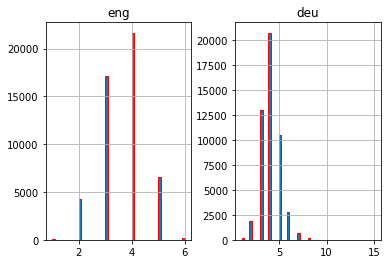

In [15]:
length_df.hist(edgecolor="red",bins=50)
plt.show()

TOKENIZATION FUNCTION

In [16]:
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

ENGLISH TOKENIZER

In [17]:
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index)+1
eng_length = 8
print('English Vocabulary size ',eng_vocab_size)

English Vocabulary size  6106


GERMAN TOKENIZATION

In [18]:
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index)+1
deu_length = 8
print('Deutch/German Vocabulary size ',deu_vocab_size)

Deutch/German Vocabulary size  10066


ENCODING AND PADDING

In [19]:
def encode_sequences(tokenizer,length,lines):
    seq = tokenizer.texts_to_sequences(lines)
    seq = pad_sequences(seq, maxlen = length,padding='post')
    return seq


**MODEL BUILDING**

In [21]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(deu_eng,test_size = 0.20,random_state = 12)

In [22]:
trainX = encode_sequences(deu_tokenizer, deu_length,train[:,1])
trainY = encode_sequences(eng_tokenizer, eng_length,train[:,0])

In [23]:
testX = encode_sequences(deu_tokenizer, deu_length,test[:,1])
testY = encode_sequences(eng_tokenizer, eng_length,test[:,0])

SEQ2SEQ ARCH, NMT MODEL , LSTM EMBEDDING

In [24]:
def build_model(in_vocab,out_vocab,in_timesteps, out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab,units,input_length=in_timesteps,mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units,return_sequences=True))
    model.add(Dense(out_vocab,activation='softmax'))
    return model

RMS OPTIMIZER

In [26]:
from tensorflow.keras import optimizers
model = build_model(deu_vocab_size,eng_vocab_size,deu_length,eng_length,512)
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms,loss='sparse_categorical_crossentropy')

From the Below Code Onwards, the system is giving lots of errors. Sometimes it randomly generates a Resource Exhaustion error on 30 epochs so Had to lower it.

After the model is trained somehow there is error in model loading and some basic prediction printing.

I tried changing the tensor flow version to 1.x to support the "predict_Classes" line but apparantely it doesn't support the model loading or some error. 


In [27]:
filename = 'model.h1.47_zeus'
checkpoint = ModelCheckpoint(filename,monitor='val_loss',verbose=1,save_best_only = True , mode ='min')
history = model.fit(trainX, trainY.reshape(trainY.shape[0],trainY.shape[1],1),epochs = 10 , batch_size = 512,validation_split = 0.2,callbacks = [checkpoint],verbose =1)
    

Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 3.3489
Epoch 1: val_loss improved from inf to 2.79320, saving model to model.h1.47_zeus


63/63 [==============================] - 184s 3s/step - loss: 3.3489 - val_loss: 2.7932
Epoch 2/10
63/63 [==============================] - ETA: 0s - loss: 2.6978
Epoch 2: val_loss improved from 2.79320 to 2.66324, saving model to model.h1.47_zeus


63/63 [==============================] - 182s 3s/step - loss: 2.6978 - val_loss: 2.6632
Epoch 3/10
63/63 [==============================] - ETA: 0s - loss: 2.5228
Epoch 3: val_loss improved from 2.66324 to 2.47619, saving model to model.h1.47_zeus


63/63 [==============================] - 180s 3s/step - loss: 2.5228 - val_loss: 2.4762
Epoch 4/10
63/63 [==============================] - ETA: 0s - loss: 2.3506
Epoch 4: val_loss improved from 2.47619 to 2.35230, saving model to model.h1.47_zeus


63/63 [==============================] - 179s 3s/step - loss: 2.3506 - val_loss: 2.3523
Epoch 5/10
63/63 [==============================] - ETA: 0s - loss: 2.1927
Epoch 5: val_loss improved from 2.35230 to 2.20759, saving model to model.h1.47_zeus


63/63 [==============================] - 180s 3s/step - loss: 2.1927 - val_loss: 2.2076
Epoch 6/10
63/63 [==============================] - ETA: 0s - loss: 2.0505
Epoch 6: val_loss improved from 2.20759 to 2.12579, saving model to model.h1.47_zeus


63/63 [==============================] - 179s 3s/step - loss: 2.0505 - val_loss: 2.1258
Epoch 7/10
63/63 [==============================] - ETA: 0s - loss: 1.9246
Epoch 7: val_loss improved from 2.12579 to 2.02990, saving model to model.h1.47_zeus


63/63 [==============================] - 178s 3s/step - loss: 1.9246 - val_loss: 2.0299
Epoch 8/10
63/63 [==============================] - ETA: 0s - loss: 1.8083
Epoch 8: val_loss improved from 2.02990 to 1.95144, saving model to model.h1.47_zeus


63/63 [==============================] - 178s 3s/step - loss: 1.8083 - val_loss: 1.9514
Epoch 9/10
63/63 [==============================] - ETA: 0s - loss: 1.7077
Epoch 9: val_loss improved from 1.95144 to 1.86361, saving model to model.h1.47_zeus


63/63 [==============================] - 179s 3s/step - loss: 1.7077 - val_loss: 1.8636
Epoch 10/10
63/63 [==============================] - ETA: 0s - loss: 1.6081
Epoch 10: val_loss improved from 1.86361 to 1.80336, saving model to model.h1.47_zeus


63/63 [==============================] - 180s 3s/step - loss: 1.6081 - val_loss: 1.8034


THE BELOW CODE THROWS THE ERROR AND ISN'T ABLE TO EXECUTE DUE TO MULTIPLE SYSTEM ERRORS NOT FOUND EVEN ON STACKOVERFLOW.



In [32]:
model = load_model('model.h1.47_zeus')


In [52]:
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(40000, 8) (40000, 8) (10000, 8) (10000, 8)


In [53]:
predict_x=model.predict(testX) 
classes_x=np.argmax(predict_x,axis=1)

In [36]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 8, 512)            5153792   
                                                                 
 lstm_2 (LSTM)               (None, 512)               2099200   
                                                                 
 repeat_vector_1 (RepeatVect  (None, 8, 512)           0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 8, 512)            2099200   
                                                                 
 dense_1 (Dense)             (None, 8, 6106)           3132378   
                                                                 
Total params: 12,484,570
Trainable params: 12,484,570
Non-trainable params: 0
__________________________________________

In [38]:
model.save('my_model.h5') 

In [42]:
import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)
new_model = tf.keras.models.load_model('my_model.h5')
new_model.summary()

2.8.2
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 8, 512)            5153792   
                                                                 
 lstm_2 (LSTM)               (None, 512)               2099200   
                                                                 
 repeat_vector_1 (RepeatVect  (None, 8, 512)           0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 8, 512)            2099200   
                                                                 
 dense_1 (Dense)             (None, 8, 6106)           3132378   
                                                                 
Total params: 12,484,570
Trainable params: 12,484,570
Non-trainable params: 0
____________________________________

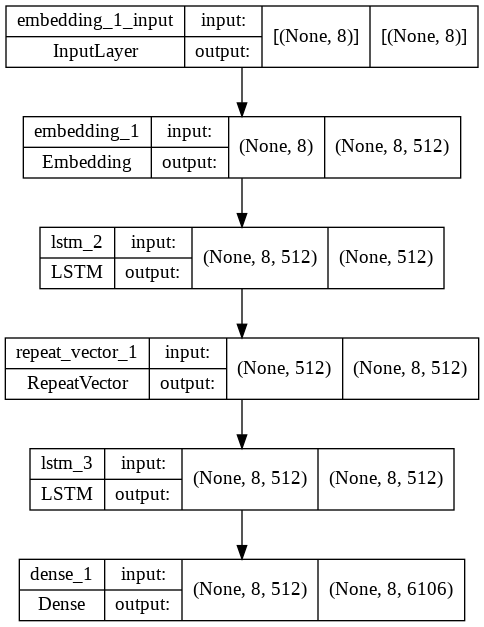

In [45]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='Model_plot.png', show_shapes=True, show_layer_names=True)

In [54]:
import pickle

dataset_dict = {"X_train": trainX, "X_test": testX, "y_train": trainY, "y_test": testY}


In [55]:
model.fit(trainX, trainY)
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

1250/1250 [==============================] - 431s 342ms/step - loss: 1.7573


In [56]:
preds = (model.predict(testX) > 0.5).astype("int32")

In [57]:
def get_word(n,tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None 

In [68]:
preds_text = []
for i in preds:
  print(i)

Streaming output truncated to the last 5000 lines.
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
[[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 